<a href="https://colab.research.google.com/github/aroonaram/Computer-Vision/blob/main/KNNonCifar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from six.moves import cPickle

In [46]:
#load the dataset
from google.colab import drive
import scipy.io as sio

google_colab = True
path = ""

if google_colab:
  from google.colab import drive, files
  drive.mount('/content/drive',force_remount=True)
  FOLDERNAME = 'cifar-10-batches-py'
  assert FOLDERNAME is not None
  import sys
  path = '/content/drive/My Drive/cifar-10-batches-py/'

Mounted at /content/drive


In [47]:
train = []
file = os.listdir(path=path)[1]

In [48]:

dict = cPickle.load(open(path+file,'rb'),encoding='bytes')

train.append(dict[b'data'])
 


In [ ]:
#train['']

In [ ]:
#np.array(train).shape # (1,10000,3071) - (layer,rows,columns)

In [50]:
def loadData(path):
    listOfTestFiles = os.listdir(path=path)
    train = []
    train_labels = []
    test = []
    test_labels = []
        
        
    print("Training files = ",listOfTestFiles)
    #For collecting Training data:
    for file in listOfTestFiles:
        with open(path+file,'rb') as fo:
            print("file name is",file)
            if file.startswith('data'):
              dict = cPickle.load(fo,encoding='bytes')
              fo.close()
              train.append(dict[b'data'])
              train_labels.append(dict[b'labels'])
            elif file.startswith('test'):
              dict = cPickle.load(fo,encoding='bytes')
              fo.close()
              test.append(dict[b'data'])
              test_labels.append(dict[b'labels'])
            else:
              pass
           
    
    dictData = {}
    dictData['train_data'] = np.reshape(np.array(train),newshape=(np.array(train).shape[0]*np.array(train).shape[1],np.array(train).shape[2]))
    dictData['train_labels'] = np.reshape(np.array(train_labels),newshape=(np.array(train_labels).shape[0]*np.array(train_labels).shape[1]))
    dictData['test_data'] = np.reshape(np.array(test),newshape=(np.array(test).shape[0]*np.array(test).shape[1],np.array(test).shape[2]))
    dictData['test_labels'] = np.reshape(np.array(test_labels),newshape=(np.array(test_labels).shape[0]*np.array(test_labels).shape[1]))
    
    return dictData
 


    

In [51]:
dataset = loadData(path ='/content/drive/My Drive/cifar-10-batches-py/')

Training files =  ['test_batch', 'data_batch_3', 'data_batch_2', 'data_batch_5', 'data_batch_1', 'data_batch_4', 'batches.meta', 'readme.html']
file name is test_batch
file name is data_batch_3
file name is data_batch_2
file name is data_batch_5
file name is data_batch_1
file name is data_batch_4
file name is batches.meta
file name is readme.html


In [52]:
dataset['train_data'].shape

(50000, 3072)

In [53]:
dataset['test_data'][1]

array([235, 231, 232, ..., 178, 191, 199], dtype=uint8)

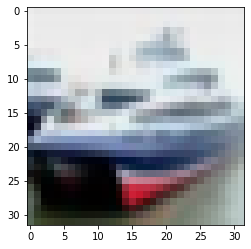

In [54]:
#visualizing train sample

def showImg(imgID):

  temp = dataset['test_data'][imgID]

  # Since every row represents one example to re-map it to image we have to form three 32,32 matrix,
  #representing RGB values

  R = temp[0:1024].reshape(32,32)
  G = np.reshape(temp[1024:2048],newshape=(32,32))
  B = np.reshape(temp[2048:],newshape=(32,32))
  temp = np.dstack((R,G,B))   #for stacking all these 32,32 matrices.
  plt.imshow(temp)
  plt.show()


showImg(1)


In [55]:
x_train,y_train, x_test, y_test = dataset['train_data'],dataset['train_labels'],dataset['test_data'],dataset['test_labels']


In [56]:

#Splitting the data into train and validation set
# train = 49000 samples and validation set = 1000 samples

train_x,train_y = x_train[0:49000],y_train[0:49000]
val_x, val_y = x_train[49000:],y_train[49000:]

print("No. of training samples = ",train_x.shape[0])
print("No. of validation set samples = ",val_x.shape[0])

No. of training samples =  49000
No. of validation set samples =  1000


In [57]:
#Building the actual classifier:
#inputs will be of shape N X F where N = number of examples and F = number of features for each image.
#labels will be of size N,1. This consists of labels for all N labels from 10 classes

class kNearestNeighbour(object):
    def __init__(self):
        pass
    
    def train(self,X,Y):
        #Knn will remember all of its training data
        self.Xtr = X
        self.Ytr = Y
        
    def predict(self,X,k):
        #to get no. of samples in train set 
        test_samples = X.shape[0]
        
        Ypred = np.zeros(test_samples,dtype=self.Ytr.dtype)
        
        #Calculating the l1 distance between current samples of test and train set
        for i in range(test_samples):
            print("Test example = ",i,end="\r")
            
            #label_count is array of zeros used to store the count for each class while comparing neighbours
            label_count = np.zeros(10,dtype=self.Ytr.dtype)    
            
            dist = np.sum(np.abs(X[i,:] - self.Xtr),axis=1)   #take the absolute sum horizontally across columns
            
            #idx will contain k smallest indices at the start of the list
            #this is called partial sorting for more information look: https://docs.scipy.org/doc/numpy/reference/generated/numpy.argpartition.html
            #min_ind will help us to slice through k indices which have minimum distance
            idx = np.argpartition(dist,k)
            min_ind = idx[:k]
            
            #This for loop iterates over min_ind and find the label present in train-set_Y for x
            #and increase the count at that particular index whenever any label is repeated.
            #Max value at any index is returned using np.argmax() and stored at ith index of Ypred i.e. predicted values
            for x in min_ind:
                label_count[int(self.Ytr[x])] +=1
            Ypred[i] = np.argmax(label_count)
    
    
        return Ypred

In [58]:
#lets use validation set for prediction and to calculate accuracy
#hyper-parameter k = 3, similarity measure = L1

knn = kNearestNeighbour()
knn.train(train_x,train_y)
val_y_pred = knn.predict(val_x,3)

#Accuracy for validation set
print('Val accuracy = ',np.mean(val_y_pred==val_y))

Val accuracy =  0.241


In [59]:
#hyper-parameter k = 5, similarity measure = L1

val_y_pred = knn.predict(val_x,5)

#Accuracy for validation set
print('Val accuracy = ',np.mean(val_y_pred==val_y))

Val accuracy =  0.263


In [60]:
#hyper-parameter k = 7, similarity measure = L1

val_y_pred = knn.predict(val_x,7)

#Accuracy for validation set
print('Val accuracy = ',np.mean(val_y_pred==val_y))

Val accuracy =  0.27


In [61]:
#hyper-parameter k = 9, similarity measure = L1

val_y_pred = knn.predict(val_x,9)

#Accuracy for validation set
print('Val accuracy = ',np.mean(val_y_pred==val_y))

Val accuracy =  0.257


In [62]:
#hyper-parameter k = 7, similarity measure = L1

test_y_pred = knn.predict(x_test,7)

#Accuracy for validation set
print('Test set accuracy = ',np.mean(test_y_pred==y_test))

Test set accuracy =  0.2788


In [63]:
# initialize the values of k for our k-Nearest Neighbor classifier along with the
# list of accuracies for each value of k
kVals = range(1, 30, 2)
accuracies = []

In [64]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn import datasets
from skimage import exposure

In [ ]:
# loop over various values of `k` for the k-Nearest Neighbor classifier
for k in range(1, 30, 2):
	# train the k-Nearest Neighbor classifier with the current value of `k`
	model = KNeighborsClassifier(n_neighbors=k)
	model.fit(train_x, train_y)

	# evaluate the model and update the accuracies list
	score = model.score(val_x, val_y)
	print("k=%d, accuracy=%.2f%%" % (k, score * 100))
	accuracies.append(score)

# find the value of k that has the largest accuracy
i = int(np.argmax(accuracies))
print("k=%d achieved highest accuracy of %.2f%% on validation data" % (kVals[i],
	accuracies[i] * 100))

k=1, accuracy=33.30%
k=3, accuracy=31.30%
k=5, accuracy=31.80%
k=7, accuracy=32.60%
k=9, accuracy=30.40%
k=11, accuracy=30.50%
k=13, accuracy=30.00%
k=15, accuracy=30.90%
